In [1]:
import os
import sys
import umap

import numpy as np
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from core.data.utils import read_all_datasets, read_all_metadata
from core.data.processing.normalization import robust_zscore_normalization_per_dataset
from core.stats.tests import test_two_groups
from core.utils.genes import entrez_id_to_gene_symbol

In [ ]:
libraries = gp.get_library_name(organism='Human')
libraries

In [3]:
DATA_DIR = '../../db'
ENRICHR_LIBRARIES = ['WikiPathway_2023_Human', 'KEGG_2021_Human', 'GO_Biological_Process_2023', 'GO_Molecular_Function_2023', 'GO_Cellular_Component_2023', 'Reactome_2022']

In [4]:
dataset, dataset_label = read_all_datasets(DATA_DIR, dropna=False)

In [5]:
dataset = entrez_id_to_gene_symbol(dataset)

4975 input query terms found no hit:	['100127886', '100127940', '100127972', '100127974', '100128046', '100128175', '100128185', '1001281


In [6]:
metadata = read_all_metadata(DATA_DIR)

In [7]:
metadata['inflammation'] = np.where(pd.isna(metadata['inflammation']) & (metadata['disease'] == 'UC'), 'Inflamed', metadata['inflammation'])
metadata['inflammation'] = np.where(pd.isna(metadata['inflammation']) & (metadata['disease'] == 'Ctrl'), 'Uninflamed', metadata['inflammation'])

In [8]:
y = metadata[(((metadata.disease == 'UC') & (metadata.inflammation == 'Inflamed')) | ((metadata.disease == 'Ctrl') & (metadata.inflammation == 'Uninflamed'))) & metadata.time_of_biopsy.isin([None, 'W0', 'Before', np.nan])].disease
dataset_labels = dataset_label.loc[y.index]
X = dataset.loc[y.index]
# X = X.dropna(axis=1)

X.shape, y.shape

((838, 25032), (838,))

In [ ]:
X_norm = robust_zscore_normalization_per_dataset(X, dataset_label)

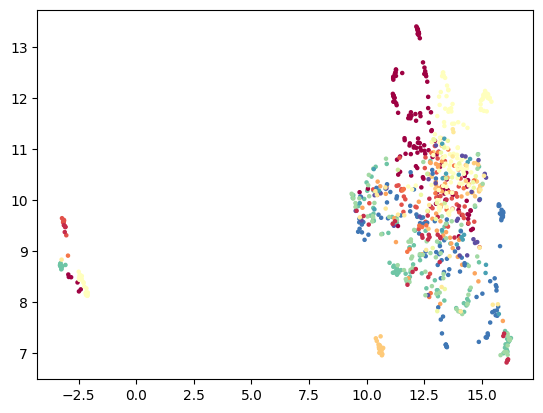

In [10]:
X_for_umap = X_norm.dropna(axis=1)

umap_embedding = umap.UMAP().fit_transform(X_for_umap)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_labels).codes, cmap='Spectral', s=5)
plt.show()

In [ ]:
test_data = X_norm.astype(float)
test_data['disease'] = y

test_results = test_two_groups(test_data, 'disease', alpha=0.05/test_data.shape[1])

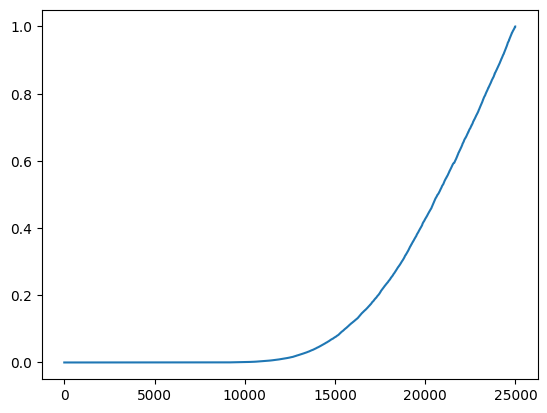

In [12]:
plt.plot([p for f, (p, d, t) in test_results]);

In [13]:
genes = [f for f, (p, d, t) in test_results if p < 0.05/test_data.shape[1]]

In [ ]:
# libraries = gp.get_library_name(organism='Human')
# print(libraries)

gene_list = genes#[:1000]

enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=ENRICHR_LIBRARIES, organism='Human', outdir='../../results/enrichr_kegg', cutoff=0.05)

In [15]:
enrichr_results.res2d[enrichr_results.res2d['Adjusted P-value'] < 0.05].sort_values('Odds Ratio', ascending=False).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
21,Reactome_2022,Formation Of ATP By Chemiosmotic Coupling R-HS...,15/16,6.703008e-07,5.465999e-05,0,0,30.452616,432.900351,DMAC2L;ATP5PF;ATP5PD;ATP5PB;ATP5MC2;ATP5MC3;AT...
59,Reactome_2022,Interleukin-21 Signaling R-HSA-9020958,9/10,3.294500e-04,9.850556e-03,0,0,18.254961,146.369847,IL21;STAT5A;STAT5B;STAT1;STAT3;IL21R;STAT4;JAK...
76,Reactome_2022,CD163 Mediating An Anti-Inflammatory Response ...,8/9,9.025242e-04,2.102764e-02,0,0,16.224174,113.736574,IL10;ADAM17;CD163;IL6;PLK2;RHBDF2;FURIN;MAPK14
99,Reactome_2022,Cross-presentation Of Particulate Exogenous An...,7/8,2.444772e-03,4.385920e-02,0,0,14.194003,85.359944,NCF1;NCF2;NCF4;CYBB;CYBA;ITGAV;CD36
25,Reactome_2022,Other Semaphorin Interactions R-HSA-416700,16/19,6.370238e-06,4.395464e-04,0,0,10.827621,129.540291,ITGB1;SEMA5A;SEMA4A;SEMA7A;CD72;SEMA6A;PLXND1;...
68,Reactome_2022,Interleukin-35 Signaling R-HSA-8984722,10/12,5.011084e-04,1.302882e-02,0,0,10.142424,77.069119,STAT1;CANX;EBI3;STAT3;STAT4;IL6ST;JAK2;IL12RB2...
8,Reactome_2022,Interleukin-10 Signaling R-HSA-6783783,37/45,1.486347e-11,2.962785e-09,0,0,9.416058,234.762241,CD86;CSF3;IL1RN;CSF2;CXCL8;CCL3L1;CSF1;CD80;PT...
84,Reactome_2022,Metallothioneins Bind Metals R-HSA-5661231,9/11,1.275782e-03,2.692651e-02,0,0,9.126799,60.822774,MT2A;MT1A;MT1M;MT1F;MT1G;MT1H;MT1X;MT3;MT1E
83,Reactome_2022,Interleukin-6 Signaling R-HSA-1059683,9/11,1.275782e-03,2.692651e-02,0,0,9.126799,60.822774,SOCS3;IL6;STAT1;STAT3;CBL;IL6ST;JAK2;IL6R;JAK1
29,Reactome_2022,Citric Acid Cycle (TCA Cycle) R-HSA-71403,17/21,8.911789e-06,5.329250e-04,0,0,8.628925,100.338305,FAHD1;IDH3G;MDH2;IDH2;SDHD;SDHA;SDHB;CS;SUCLA2...


In [16]:
enrichr_results.res2d[enrichr_results.res2d['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes


In [17]:
test_data = X.astype(float)
test_data['disease'] = y

In [ ]:
# Now let's try the same analysis but for each dataset separately

test_data = X.astype(float)
test_data['disease'] = y

all_test_results = []
all_enrichment_results = pd.DataFrame()
for dataset_name in dataset_labels.unique():
    print()
    print(dataset_name)
    datset_test_data = test_data[dataset_labels == dataset_name]

    if datset_test_data.shape[0] < 5:
        print('Skipping dataset', dataset_name, 'because of small sample size')
        continue

    if datset_test_data['disease'].nunique() < 2:
        print('Skipping dataset', dataset_name, 'because there is only one class present in the dataset')
        continue

    datset_test_results = test_two_groups(datset_test_data, 'disease', alpha=0.05/datset_test_data.shape[1])
    all_test_results.append((dataset_name, datset_test_results))
    
    genes = [f for f, (p, d, t) in datset_test_results if p < 0.05/datset_test_data.shape[1]]

    gene_list = genes

    if len(gene_list) == 0:
        print('No significant genes found for dataset', dataset_name)
        continue

    for library in ENRICHR_LIBRARIES:
        enrichr_results = gp.enrichr(gene_list=gene_list, gene_sets=[library], organism='Human', cutoff=0.05)
        enrichr_results.res2d['dataset'] = dataset_name
        enrichr_results.res2d['rank'] = range(1, len(enrichr_results.res2d) + 1)
        enrichr_results.res2d['library'] = library
        all_enrichment_results = pd.concat([all_enrichment_results, enrichr_results.res2d])

In [19]:
# Now let's order the pathways by their mean position in the ranking
all_enrichment_results['rank'] = all_enrichment_results['rank'].astype(int)
all_enrichment_results.groupby('Term')['rank'].mean().sort_values().head(20)

Term
Mitochondrial Fatty Acid Oxidation Disorders WP5123                                                    4.000000
Intracellular Organelle Lumen (GO:0070013)                                                             5.285714
Granulocyte Chemotaxis (GO:0071621)                                                                    7.666667
Mitochondrial Long Chain Fatty Acid Beta Oxidation WP368                                               9.000000
TNF signaling pathway                                                                                  9.833333
Mitochondrial Matrix (GO:0005759)                                                                     10.428571
Neutrophil Chemotaxis (GO:0030593)                                                                    11.166667
Peroxisome (GO:0005777)                                                                               11.666667
Protein Homodimerization Activity (GO:0042803)                                                     

In [20]:
all_enrichment_results[all_enrichment_results['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,dataset,rank,library
2,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,17/19,9.373871e-09,2.455954e-06,0,0,24.561807,454.033337,PECR;CPT1A;ACADVL;SLC22A5;ACSL1;ECI1;ACSL4;ACS...,GSE75214,3,WikiPathway_2023_Human
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,5/19,5.193505e-04,1.441198e-01,0,0,9.338606,70.627241,PECR;HADHA;SLC22A5;ECI1;ACSF2,GSE11223,2,WikiPathway_2023_Human
1,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,13/19,3.356960e-10,1.171579e-07,0,0,22.375378,488.114735,PECR;CPT1A;SLC22A5;ECI1;ACSL4;ACSF2;HADHB;HADH...,GSE179285,2,WikiPathway_2023_Human
9,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,14/19,3.273977e-08,2.507867e-06,0,0,14.910288,256.973972,PECR;CPT1A;SLC22A5;ECI1;ACSL4;ACSF2;HADHB;HADH...,GSE92415,10,WikiPathway_2023_Human
5,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,13/19,2.230203e-06,2.884397e-04,0,0,9.720254,126.493731,PECR;CPT1A;ACADVL;SLC22A5;ACSL4;ACSF2;HADHB;HA...,GSE73661,6,WikiPathway_2023_Human
0,WikiPathway_2023_Human,Mitochondrial Fatty Acid Oxidation Disorders W...,9/19,2.129845e-08,1.269388e-05,0,0,21.110894,372.916156,HADHB;HADHA;SLC22A5;SCP2;ECI1;ACADM;SLC25A20;A...,GSE16879,1,WikiPathway_2023_Human


In [21]:
dataset_labels.value_counts()

dataset
GSE48634     137
GSE11223     132
GSE92415     108
GSE75214      96
GSE73661      79
GSE179285     54
GSE23597      45
GSE3629       43
GSE16879      36
GSE9452       26
GSE36807      22
GSE22619      20
GSE87465      19
GSE52746      17
GSE72780       4
Name: count, dtype: int64

In [22]:
foa_genes = np.unique(sum([g.split(';') for g in all_enrichment_results[all_enrichment_results['Term'] == 'Mitochondrial Fatty Acid Oxidation Disorders WP5123'].Genes], []))

foa_genes

array(['ACADM', 'ACADS', 'ACADVL', 'ACSF2', 'ACSL1', 'ACSL3', 'ACSL4',
       'CPT1A', 'CPT2', 'ECI1', 'EHHADH', 'HADH', 'HADHA', 'HADHB',
       'PECR', 'SCP2', 'SLC22A5', 'SLC25A20'], dtype='<U8')

In [23]:
all_results = pd.DataFrame()
for dr in all_test_results:
    asdf = pd.DataFrame([[g, p, m] for g, (p, m, t) in dr[1]])
    asdf['dataset'] = dr[0]
    all_results = pd.concat([all_results, asdf])

all_results.columns = ['gene', 'p', 'diff', 'dataset']

significant_results = all_results[all_results['p'] < 0.05/test_data.shape[1]]

significant_foa_genes = significant_results[significant_results['gene'].isin(foa_genes)]

(significant_foa_genes['diff'] < 0).value_counts()

diff
True     65
False     6
Name: count, dtype: int64

In [24]:
significant_foa_genes[significant_foa_genes['diff'] > 0]

,gene,p,diff,dataset
1187,ACSL4,6.658278e-12,2.390821,GSE75214
3024,ACSL1,4.810241e-09,1.527594,GSE75214
4664,ACSL3,5.812219e-07,0.545680,GSE75214
571,ACSL4,2.655154e-08,0.238705,GSE179285
1159,ACSL4,1.158453e-09,1.132061,GSE92415
1064,ACSL4,2.984185e-09,2.141611,GSE73661


In [25]:
significant_foa_genes.reset_index().rename(columns={'index': 'rank'}).groupby('gene')['rank'].agg(['mean', 'median', 'count']).sort_values('mean')

,mean,median,count
gene,,,
ACADS,216.000000,126.0,5
CPT1A,255.750000,186.5,4
SLC25A20,278.200000,274.0,5
SLC22A5,362.500000,412.0,6
ACADM,550.400000,212.0,5
HADHB,559.400000,536.0,5
ACSF2,594.666667,538.0,6
ECI1,726.800000,156.0,5
EHHADH,736.000000,736.0,1


In [26]:
(significant_results['diff'] < 0).value_counts(dropna=False)

diff
True     7764
False    7612
Name: count, dtype: int64

In [27]:
pathways = {}
for library in ENRICHR_LIBRARIES:
    pathway = gp.get_library(name=library, organism='Human')
    pathways.update(pathway)

In [28]:
no_genes = X.shape[1]

pathway_ranks = pd.DataFrame()
for dataset_name in significant_results.dataset.unique():
    print(dataset_name)
    dataset_results = significant_results[significant_results['dataset'] == dataset_name]
    dataset_results = dataset_results.reset_index().rename(columns={'index': 'rank'})
    
    for pathway in pathways:
        pathway_genes = pathways[pathway]
        pathway_genes_rank = dataset_results[dataset_results['gene'].isin(pathway_genes)]['rank'].tolist()
        if len(pathway_genes_rank) == 0:
            continue

        pathway_rank_weighted_sum = np.sum([(no_genes - r) / no_genes for r in pathway_genes_rank])
        pathway_no_genes = len(pathway_genes)
        pathway_score = pathway_rank_weighted_sum / pathway_no_genes

        pathway_ranks = pd.concat([pathway_ranks, pd.DataFrame({'dataset': dataset_name, 'pathway': pathway, 'genes': str(pathway_genes), 'ranks': str(pathway_genes_rank), 'mean_rank': np.mean(pathway_genes_rank), 'no_genes': len(pathway_genes_rank), 'weighted_sum': pathway_rank_weighted_sum, 'total_genes': pathway_no_genes, 'score': pathway_score}, index=[0])])

GSE75214
GSE11223
GSE179285
GSE92415
GSE48634
GSE9452
GSE73661
GSE16879
GSE36807


In [29]:
pathway_ranks.groupby('pathway')['score'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False).head(20)

,mean,median,count
pathway,,,
Regulation Of Basement Membrane Organization (GO:0110011),0.746692,0.753124,4
Glomerulus Vasculature Development (GO:0072012),0.708767,0.740352,4
Beta Oxidation Of hexanoyl-CoA To butanoyl-CoA R-HSA-77350,0.707273,0.672995,6
Beta Oxidation Of octanoyl-CoA To hexanoyl-CoA R-HSA-77348,0.705047,0.673594,6
G2/M DNA Replication Checkpoint R-HSA-69478,0.692753,0.692753,1
Lipoprotein Metabolic Process (GO:0042157),0.679682,0.679682,1
Activin Receptor Complex (GO:0048179),0.657401,0.646081,4
Leukocyte Aggregation (GO:0070486),0.656498,0.671535,6
Arachidonic Acid AA ARA Oxylipin Metabolism WP5155,0.643015,0.720947,6


## Test for genes involved in ferroptosis

In [65]:
ferroptosis_related_genes = ['AIFM2', 'PROM2', 'TFRC', 'NFE2L2', 'FTMT', 'NCOA4', 'SERPINH1']

significant_results[significant_results.gene.isin(ferroptosis_related_genes)].sort_values('gene')

,gene,p,diff,dataset
85,NCOA4,9.043152e-24,-0.582015,GSE75214
23,NCOA4,3.185628e-11,-0.103353,GSE11223
1226,NCOA4,3.916490e-07,-0.743827,GSE179285
741,NCOA4,1.019799e-10,-0.397002,GSE73661
1509,PROM2,5.816079e-09,-0.459952,GSE92415
2570,SERPINH1,1.018994e-09,0.875461,GSE75214
2762,SERPINH1,5.758760e-07,0.800824,GSE92415


# Experiments with normalization

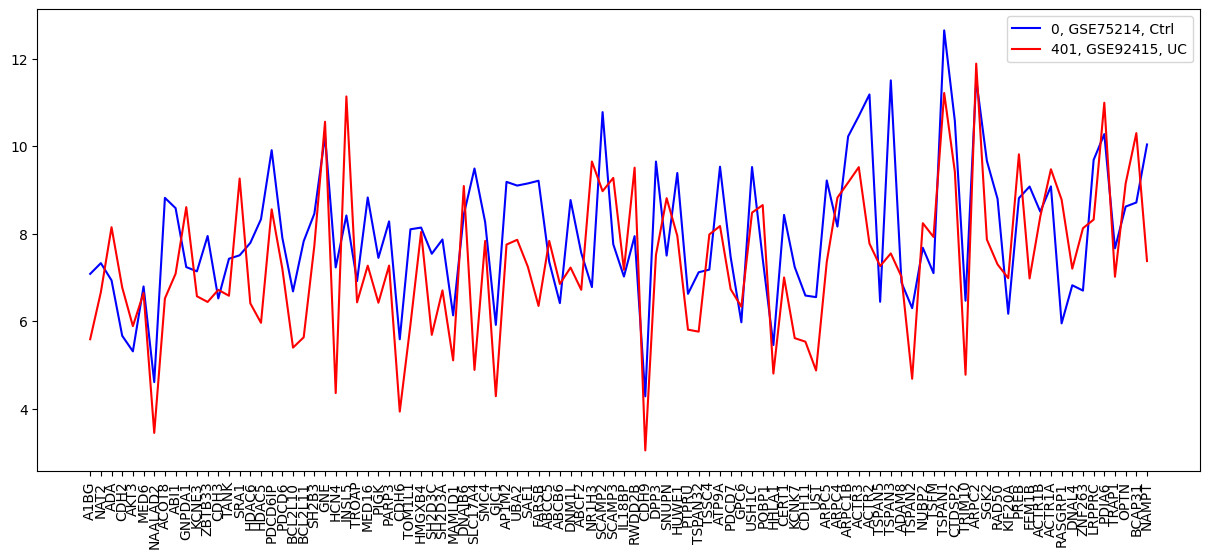

In [31]:
idx_0 = 0
idx_1 = 401
start_feature = 000
end_feature = 100
sample_0 = X.dropna(axis=1).iloc[idx_0, start_feature:end_feature]
sample_1 = X.dropna(axis=1).iloc[idx_1, start_feature:end_feature]

plt.figure(figsize=(15, 6));
plt.plot(sample_0, 'b');
plt.plot(sample_1, 'r');
plt.xticks(rotation=90);
plt.legend([f'{idx_0}, {dataset_labels.iloc[idx_0]}, {y.iloc[idx_0]}', f'{idx_1}, {dataset_labels.iloc[idx_1]}, {y.iloc[idx_1]}']);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_30034/4239693137.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_30034/4239693137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
UC


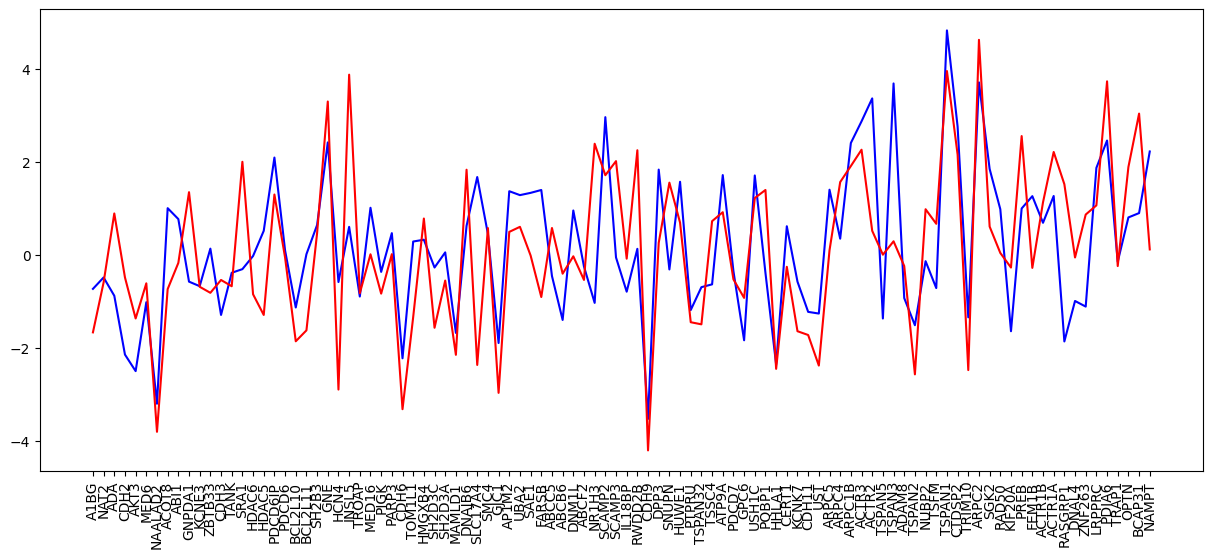

In [32]:
median_0, median_1 = sample_0.median(), sample_1.median()

plt.figure(figsize=(15, 6));
plt.plot(sample_0 - median_0, 'b');
print(y[idx_0])
plt.plot(sample_1 - median_1, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_30034/224693890.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_0])
/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_30034/224693890.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[idx_1])


Ctrl
UC


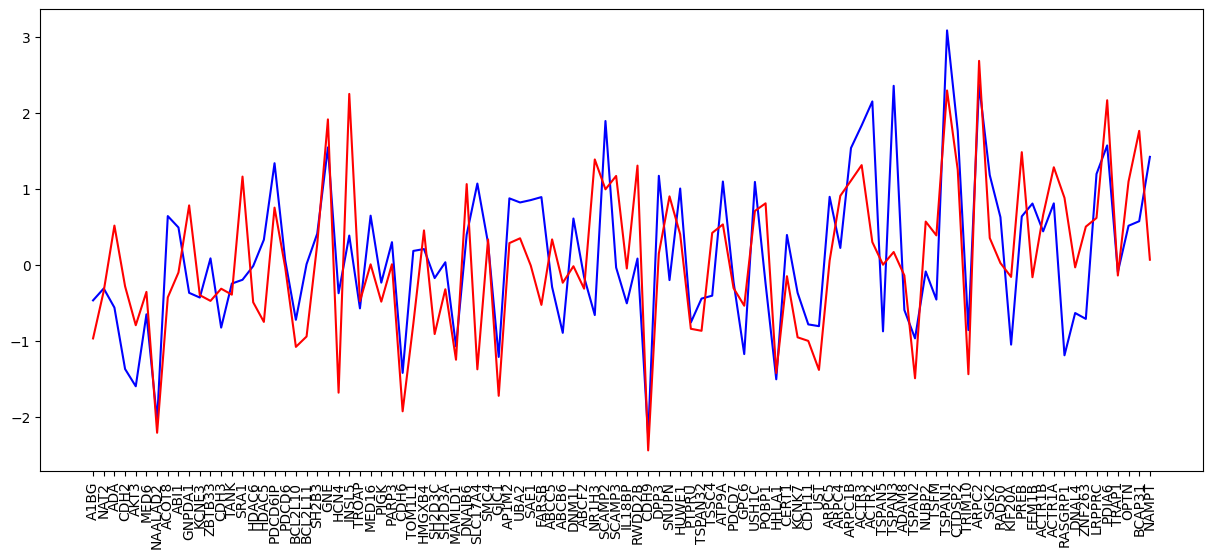

In [33]:
median_0, median_1 = sample_0.median(), sample_1.median()

sample_0_norm = (sample_0 - median_0)/(sample_0.std())
sample_1_norm = (sample_1 - median_1)/(sample_1.std())

plt.figure(figsize=(15, 6));
plt.plot(sample_0_norm, 'b');
print(y[idx_0])
plt.plot(sample_1_norm, 'r');
print(y[idx_1])
plt.xticks(rotation=90);

In [34]:
X[dataset_labels == dataset_labels.iloc[idx_0]]

ENTREZ_ID,A1BG,NAT2,ADA,CDH2,AKT3,GAGE12F,ZBTB11-AS1,MED6,NR2E3,NAALAD2,...,EEF1DP6,PDCL3P5,HNRNPA1P52,RPL12P8,LOC645397,CLIC4P1,LLPHP3,UQCRFS1P2,PRAMEF32P,ZNF66
GSM1426079,7.083244,7.328548,6.934914,5.668903,5.313481,5.869368,7.488339,6.795918,6.211544,4.611238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1426080,6.827223,7.515203,6.964368,5.975487,6.717288,5.937392,7.494217,7.094214,6.208656,4.503998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1426081,6.988929,8.205227,7.091171,5.800963,5.160249,5.925015,7.006349,6.894705,6.039917,4.386274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1426082,6.895175,7.881254,6.711199,5.746755,5.022792,5.914796,7.389067,6.862267,5.930869,4.381524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1426083,7.097687,7.457055,7.111411,5.800018,5.560727,5.847466,7.131792,6.538965,5.990899,4.744934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1945832,7.265696,7.190718,7.020465,5.719514,5.862446,6.241576,7.604557,6.180662,6.462763,4.430305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1945833,6.834410,6.973490,7.166132,5.702490,7.647660,6.301552,7.210400,6.843144,6.053951,4.750890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1945834,6.962663,7.164545,7.186180,5.865514,6.582998,6.078955,7.245945,6.819287,6.053029,4.514144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM1945835,6.899814,8.022054,7.135285,5.814986,6.467930,5.673085,7.216600,6.843276,6.071191,4.500340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
